In [1]:
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
##################################     R E T 3 A T R      S T R A T E G Y       ###########################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################

In [2]:
# CLEAR VAR
from clearall import clearall
clearall()

In [3]:
# LIBRAIRIES
import pandas as pd
import numpy as np
import time
import talib
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))


In [4]:
%%time

x = 'EUR/USD'
TICKERS = [x]
_period = 'm5'

# On charge la base, et on enlève les colonnes inutiles pour ce modèle
df = pd.read_csv('Base_Clean/'+x.replace('/','')+_period+'.csv')
df = df.drop(['HigMax','LowMin','Total'],axis=1)

# On enlève les 20% de la fin qu'on garde pour le OOST
df = df.iloc[:-int(len(df) * 0.2),:]
print('Les 20% de la fin ont été enlevé pour un OOST ultérieur')

Les 20% de la fin ont été enlevé pour un OOST ultérieur
CPU times: user 1.5 s, sys: 157 ms, total: 1.66 s
Wall time: 1.66 s


In [5]:
# VANILLA TEST ON RETURN

In [6]:
%%time
df['Return3Neg'] = (df['CloseAsk'] - df['CloseBid'].shift(3))/df['CloseBid'].shift(3) # => Calcul des return qui devront être négatifs
df['Return3Pos'] = (df['CloseBid'] - df['CloseAsk'].shift(3))/df['CloseAsk'].shift(3) # => Calcul des return qui devront être positifs

# On remplit la colonne return avec les négatifs de Return3Neg et les positifs de Return3Pos
df['Return3'] = np.where(df['Return3Pos']>0,df['Return3Pos'],np.where(df['Return3Neg']<0,df['Return3Neg'],0)) 

df['ATR'] = talib.ATR(df['High'],df['Low'],df['Close'],timeperiod=5) # => Calcul de l'ATR

#df['ADRAsk'] = talib.ATR(df['HighAsk'],df['LowAsk'],df['CloseAsk'],timeperiod=288) # => Calcul de l'ADR
#df['ADRBid'] = talib.ATR(df['HighBid'],df['LowBid'],df['CloseBid'],timeperiod=288) # => Calcul de l'ADR
#df['ADRMin'] = abs(df['ADRAsk'] - df['LowAsk'].rolling(5).min())
#df['ADRMax'] = abs(df['ADRBid'] + df['HighBid'].rolling(5).max())

df['Signal'] = np.where(df['Return3']>0,1,np.where(df['Return3']<0,-1,0))

df.Signal = df.Signal.shift(-1) # => On met le Signal de la bougie d'après à la ligne d'avant pour l'apprentissage

df.rename(columns={'OpenBid':'Open_Bid','HighBid':'High_Bid','LowBid':'Low_Bid','CloseBid':'Close_Bid',\
    'OpenAsk':'Open_Ask','HighAsk':'High_Ask','LowAsk':'Low_Ask','CloseAsk':'Close_Ask'},inplace = True)

df = df.dropna()
# On normalise les inputs entre -1 et 1
df['Return3'] = scaler.fit_transform(df['Return3'].to_numpy().reshape(-1, 1))
df['ATR'] = scaler.fit_transform(df['ATR'].to_numpy().reshape(-1, 1))



CPU times: user 238 ms, sys: 77.7 ms, total: 315 ms
Wall time: 318 ms


In [7]:
len(df[df.Signal == -1]),len(df[df.Signal == 1]),abs(len(df[df.Signal == -1])-len(df[df.Signal == 1])),len(df[df.Signal == 0])

(202210, 201791, 419, 197118)

CPU times: user 322 ms, sys: 53 ms, total: 376 ms
Wall time: 402 ms


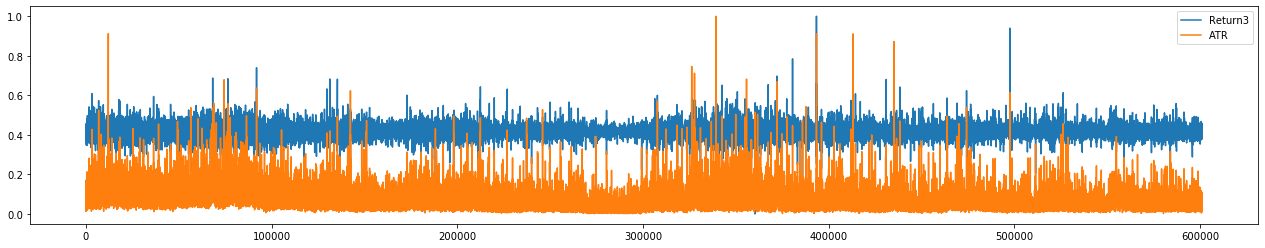

In [8]:
%%time
df[['Return3','ATR']].plot(figsize=(22,4))

In [9]:
from multiclass_mlpclassifier import modelize
_model = 'multiclass_mlpclassifier'

_t1 = dt.datetime.now()
print('Début des opérations horodatée à',dt.datetime.now())
for x in TICKERS:
    modelize(df,x,_model)
print("\n\n ===> MODELISATION terminée.")
_t2 = dt.datetime.now()
print("Temps d'excution du module",str((_t2 - _t1)))

Début des opérations horodatée à 2020-11-19 16:16:25.774665
 MultiClass MLPClassifier pour  EUR/USD 
Modèle : multiclass_mlpclassifier
COMPUTING
Signaux Counter({-1.0: 202210, 1.0: 201791, 0.0: 197118})
Iteration 1, loss = 1.09314674
Iteration 2, loss = 1.00199509
Iteration 3, loss = 0.92799200
Iteration 4, loss = 0.91816896
Iteration 5, loss = 0.91264033
Iteration 6, loss = 0.90869453
Iteration 7, loss = 0.90471049
Iteration 8, loss = 0.90091908
Iteration 9, loss = 0.89821895
Iteration 10, loss = 0.89680512
Iteration 11, loss = 0.89513828
Iteration 12, loss = 0.89377569
Iteration 13, loss = 0.89306364
Iteration 14, loss = 0.89202231
Iteration 15, loss = 0.89125963
Iteration 16, loss = 0.89053925
Iteration 17, loss = 0.89008438
Iteration 18, loss = 0.88937873
Iteration 19, loss = 0.88813709
Iteration 20, loss = 0.88837282
Iteration 21, loss = 0.88672176
Iteration 22, loss = 0.88690871
Iteration 23, loss = 0.88593987
Iteration 24, loss = 0.88572328
Iteration 25, loss = 0.88554275
Iterat

In [26]:
%%time
import joblib
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,classification_report
import colorama as col
print(col.Fore.GREEN+'###############################################################################################################################################################\n###############################################################################################################################################################\n######################################################################      O O S T      ######################################################################\n###############################################################################################################################################################\n###############################################################################################################################################################',col.Style.RESET_ALL)


df = pd.read_csv('Base_Clean/'+x.replace('/','')+_period+'.csv')
df = df.iloc[-int(len(df) * 0.2):,:]
df = df.drop(['HigMax','LowMin','Total'],axis=1)
df.index = pd.to_datetime(df['Date'])
df = df.drop(['Date'],axis=1)
print('Longueur df',len(df))
price = df.copy()

###################
print('Préparation des inputs\n')

price['Return3Neg'] = (price['CloseAsk'] - price['CloseBid'].shift(3))/price['CloseBid'].shift(3) # => Calcul des return qui devront être négatifs
price['Return3Pos'] = (price['CloseBid'] - price['CloseAsk'].shift(3))/price['CloseAsk'].shift(3) # => Calcul des return qui devront être positifs

# On remplit la colonne return avec les négatifs de Return3Neg et les positifs de Return3Pos
price['Return3'] = np.where(price['Return3Pos']>0,price['Return3Pos'],np.where(price['Return3Neg']<0,price['Return3Neg'],0)) 

price['ATR'] = talib.ATR(price['High'],price['Low'],price['Close'],timeperiod=5) # => Calcul de l'ATR

#df['ADRAsk'] = talib.ATR(df['HighAsk'],df['LowAsk'],df['CloseAsk'],timeperiod=288) # => Calcul de l'ADR
#df['ADRBid'] = talib.ATR(df['HighBid'],df['LowBid'],df['CloseBid'],timeperiod=288) # => Calcul de l'ADR
#df['ADRMin'] = abs(df['ADRAsk'] - df['LowAsk'].rolling(5).min())
#df['ADRMax'] = abs(df['ADRBid'] + df['HighBid'].rolling(5).max())

price['Signal'] = np.where(price['Return3']>0,1,np.where(price['Return3']<0,-1,0))

price.Signal = price.Signal.shift(-1) # => On met le Signal de la bougie d'après à la ligne d'avant pour l'apprentissage

price = df.dropna()

df_Signal = pd.DataFrame()
df_Signal = df_Signal.reindex_like(price)

df_Signal['Signal'] = np.where(df['Return3']>0,1,np.where(df['Return3']<0,-1,0)))

df_Signal.Signal = df_Signal.Signal.shift(-1) # => On met le Signal de la bougie d'après à la ligne d'avant pour l'apprentissage
df_Signal = df_Signal[['Signal']]

# On normalise les inputs entre -1 et 1
price['Return3'] = scaler.fit_transform(price['Return3'].to_numpy().reshape(-1, 1))
price['ATR'] = scaler.fit_transform(df['ATR'].to_numpy().reshape(-1, 1))

print('Test longueur après dropna (price/df_Signal)',len(price),len(df_Signal))
###################

price.rename(columns={'OpenBid':'Open_Bid','HighBid':'High_Bid','LowBid':'Low_Bid','CloseBid':'Close_Bid',\
    'OpenAsk':'Open_Ask','HighAsk':'High_Ask','LowAsk':'Low_Ask','CloseAsk':'Close_Ask'},inplace = True)


loaded_model = joblib.load('JOBLIB/'+_model+'/SaveEURUSDm5.sav')
price['Signal'] = loaded_model.predict(price[['Return3','ATR']])
price['Proba'] = 999
price['Proba'] = loaded_model.predict_proba(price[['Return3','ATR']]) * 100


print('Max Buy Signal Number 0/1/-1/total:',len(price[price.Signal==0]),len(price[price.Signal==1]),len(price[price.Signal==-1]),len(price))

print('Bases chargées')

print('TETEL process effectué')

print(col.Fore.CYAN,'ENTERING THE BACKTEST',col.Style.RESET_ALL)
    

resultat = pd.DataFrame()
resultat = resultat.reindex_like(df_Signal)
resultat['Controle'] = df_Signal.Signal.to_list()
resultat = resultat[['Controle']]
price = price.dropna()
#resultat = resultat.dropna()
resultat = resultat.fillna(0)
accu = round(accuracy_score(resultat['Controle'], price['Signal']) * 100,2)
prec = round(precision_score(resultat['Controle'], price['Signal'],average='micro') * 100,2)
recall = round(recall_score(resultat['Controle'], price['Signal'],average='micro') * 100,2)
f1 = round(f1_score(resultat['Controle'], price['Signal'],average='micro') * 100,2)
print(col.Fore.BLUE,'Achat pour',col.Fore.YELLOW,x,col.Style.RESET_ALL)
if accub > 69 and precb > 69 :
    print(col.Fore.GREEN)
elif accub < 51 or precb < 51 :
    print(col.Fore.RED)
else:
    print(col.Fore.YELLOW)

print('Achat - Accuracy :' ,accu,'%')
print('Achat - Precision :',prec,'%')
print('Achat - Recall :', recall,'%')
print('Achat - F-measure: :' ,f1,'%',col.Style.RESET_ALL)
print('\n')
print(col.Style.RESET_ALL)
print(classification_report(resultat['Controle'], price['Signal']))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(resultat['Controle'], price['Signal']))
print('\n',conf_matrix)
print('\n')





###############################################################################################################################################################
###############################################################################################################################################################
######################################################################      O O S T      ######################################################################
###############################################################################################################################################################
############################################################################################################################################################### 
Longueur df 150281
Préparation des inputs

Test longueur après dropna (price/df_Signal) 150276 150276
Max Buy Signal Number 0/1/-1/total: 0 522 149754 150276
Bases chargées
TETEL process effectué
 EN

In [24]:
len(resultat),len(resultat.dropna()),len(price),len(price.dropna())

(150276, 150275, 150276, 150276)

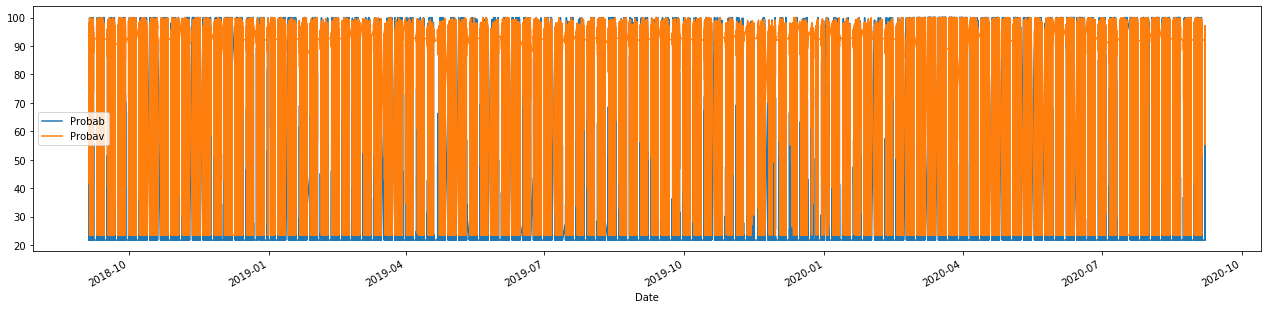

In [11]:
price[['Probab','Probav']].plot(figsize=(22,5))

In [14]:
len(price[(price.Signalb==1)&(price.Signalv==1)]),len(price[(price.Signalb==0)&(price.Signalv==0)]),len(price[(price.Signalb==1)&(price.Signalv==0)]),len(price[(price.Signalb==0)&(price.Signalv==1)])

(1092, 5000, 130721, 13463)

Date
2018-09-04 23:00:00    100.0
2018-09-04 23:05:00    100.0
2018-09-04 23:10:00    100.0
2018-09-04 23:15:00    100.0
2018-09-04 23:20:00    100.0
                       ...  
2020-09-07 00:40:00    100.0
2020-09-07 00:45:00    100.0
2020-09-07 00:50:00    100.0
2020-09-07 00:55:00    100.0
2020-09-07 01:00:00    100.0
Name: Toto, Length: 150276, dtype: float64

In [12]:
###########
## BT VANILLA => TIME EXIT AND/OR REVERSAL SIGNAL
#######

In [21]:
%%time
print('Importing Librairies...')
import colorama as col
import pandas as pd
import time
import os
import datetime as dt
import numpy as np
import talib
import pyttsx3
import joblib

engine = pyttsx3.init()

print('Librairies imported\n')

engine.say("librairie loaded")
engine.runAndWait()

#from numpy import loadtxt
#from functools import reduce
_t1 = dt.datetime.now()
print('Début des opérations horodatée à',dt.datetime.now())

number = 10000
_period = 'm5'
_period2 = 'H1'
_period3 = 'D1'
_total = 0
_cash_ini = 200000
_cash = _cash_ini
_rate = 1
#_flag = 0

DATE = []
CONTRACT = []
OPEN_POZ = []
CLOSE_POZ = []
RATE_OPEN_POZ = []
RATE_CLOSE_POZ = []
PNL_LAT = []
PNL_REAL = []
TOTAL_OPEN = []
TOTAL_CLOSE = []
PRICE_BUY = []
PRICE_SELL = []
DER_POZ = []
TOTAL_PNL_LAT = []
TOTAL_PNL_REAL = []
_cash = _cash_ini
WINNERS = []
LOOSERS = []
SIGNAL = []
OPEN = []
OPEN_BID = []
OPEN_ASK = []
EXPO_MAX = []


_atr = 80
_year_bottom = '2018-04-07 22:45:00'
_year_top = '2020-05-07 00:55:00'

_nb_bougie_exit = 10
_trigger_reengage = 0
_trigger_target = 0
_trigger_exposure = 10

_verbose = 0

df_resultats = pd.DataFrame(index=['TimeFrame 1','TimeFrame2','Equity','Nbre Winners','Nbre Loosers','Max lenght of trade','Min lenght of trade',\
    'Average lenght of trade','Cumul pnl'])

print('\nChargement de la nouvelle base\n\n')

##########################################################
##########################################################
##########################################################

engine.say("קדימה")
engine.runAndWait()

position = 0

print(col.Fore.MAGENTA,'Le rate du ticker',x,'est à ',_rate,col.Style.RESET_ALL)

price = price[(price.index >= _year_bottom) & (price.index <= _year_top)]
print('Bases chargées')

print('TETEL process effectué')

print(col.Fore.CYAN,'ENTERING THE BACKTEST',col.Style.RESET_ALL)
    
price = price.dropna()

_position = 0
_equity = 0
_nbtransactions = 0
backtest_graph = pd.DataFrame()
EQUITY = [_cash]
CASH = [_cash]
_winner = 0
_looser = 0
_index_entry = 0
TRADE_DURATION = []
_average_duration = 0
_size = 50000

PRICE_BUY = []
PRICE_SELL = []

_total = 0

_target = 0.0015

_open_buy = 0
_open_sell = 0

for i in range(0,len(price)):
    
    if _position == 0:
        # BUY SIGNAL
        if  price.Signalb[i] == 10 and price.Signalb[i-1] == 0 and price.Signalv[i] == 0 and price.Signalv[i-1] == 1: #and price.Low_Ask[i] >= price.ADRMin[i]: 
        #if  price.Probab[i] <= 30 :
            _pnl = 0
            _open_buy += 1
            _equity = _cash + _pnl
            EQUITY.append(_equity)
            CASH.append(_cash)
            _position = 1
            _index_entry = i
            _nbtransactions += 1
            price_buy = price.Close_Ask.iloc[i]
            PRICE_BUY.append(price_buy)
            _price_buy_mean = round(sum(PRICE_BUY)/len(PRICE_BUY),5)
            if _verbose == 1:
                print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                print('Position 1 bought at', price_buy,'(verification liste',PRICE_BUY[-1],')')

            DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
            CONTRACT.append(x)
            OPEN_POZ.append(1)
            CLOSE_POZ.append(0)
            RATE_OPEN_POZ.append(price_buy)
            RATE_CLOSE_POZ.append(0)
            PNL_LAT.append(_pnl)
            PNL_REAL.append(0)
            TOTAL_OPEN.append(1) 
            TOTAL_PNL_LAT.append(_pnl)
            TOTAL_PNL_REAL.append(0) 

        
        
        # SELL SIGNAL
        #elif price.Probab[i] <= -10 :
        elif price.Signalv[i] == 1 and price.Signalv[i-1] == 0 : #and price.High_Bid[i] < price.ADRMax[i] :  
            _pnl = 0
            _open_sell += 1
            _equity = _cash + _pnl
            EQUITY.append(_equity)
            CASH.append(_cash)
            _index_entry = i
            _position = -1
            _nbtransactions += 1
            price_sell = price.Close_Bid.iloc[i]
            PRICE_SELL.append(price_sell)
            _price_sell_mean = round(sum(PRICE_SELL)/len(PRICE_SELL),5)
            if _verbose == 1:
                print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                print('Position 1 sold at', price_sell,'(verification liste',PRICE_SELL[-1],')')

            DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
            CONTRACT.append(x)
            OPEN_POZ.append(-1)
            CLOSE_POZ.append(0)
            RATE_OPEN_POZ.append(price_sell)
            RATE_CLOSE_POZ.append(0) 
            PNL_LAT.append(_pnl)
            PNL_REAL.append(0)
            TOTAL_PNL_LAT.append(_pnl)
            TOTAL_PNL_REAL.append(0)

            TOTAL_OPEN.append(1)

        else :
            _pnl = 0
            _equity = _cash + _pnl
            EQUITY.append(_equity)
            CASH.append(_cash)
    
    elif _position == 1:
        
        ### CLOSE LONG ON TIME EXIT
        if i - _index_entry >= _nb_bougie_exit:
            _position = 0
            _pnl = (price.Close_Bid.iloc[i] - _price_buy_mean) * _size * _open_buy
            _total += _pnl
            _cash += _pnl
            _equity = _cash
            EQUITY.append(_equity)
            EXPO_MAX.append(_open_buy)
            CASH.append(_cash)
            if _pnl >=0:
                _winner += _open_buy
            else:
                _looser += _open_buy

            TRADE_DURATION.append(i - _index_entry)
            if _verbose == 1:
                print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                if _pnl < 0:
                    print(_open_buy,'positions SL closed at',price.Close_Bid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                else :
                    print(_open_buy,'positions SL closed at',price.Close_Bid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                print('nombre de candles en position :',i - _index_entry)
                print('Equity :', _equity)

            DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
            CONTRACT.append(x)
            OPEN_POZ.append(0)
            CLOSE_POZ.append(1)
            RATE_OPEN_POZ.append(0)
            RATE_CLOSE_POZ.append(price.Close_Bid.iloc[i])
            PNL_LAT.append(0)
            PNL_REAL.append(_pnl)
            TOTAL_CLOSE.append(_open_buy) 
            TOTAL_PNL_LAT.append(0)
            TOTAL_PNL_REAL.append(_pnl)
            PRICE_BUY = []
            _open_buy = 0

        ### RE_ENGAGE BUY ON VALID SIGNAL
        if price.Signalb[i] == 1 and price.Signalb[i-1] == 1 and i - _index_entry < _nb_bougie_exit and _trigger_reengage == 1 and _open_buy < _trigger_exposure :
            _pnl = 0
            _open_buy += 1
            _equity = _cash + _pnl
            EQUITY.append(_equity)
            CASH.append(_cash)
            _position = 1
            _index_entry = i
            _nbtransactions += 1
            price_buy = price.Close_Ask.iloc[i]
            PRICE_BUY.append(price_buy)
            _price_buy_mean = round(sum(PRICE_BUY)/len(PRICE_BUY),5)
            if _verbose == 1:
                print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                print('Position 1 bought at', price_buy,'(verification liste',PRICE_BUY[-1],')')

            DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
            CONTRACT.append(x)
            OPEN_POZ.append(1)
            CLOSE_POZ.append(0)
            RATE_OPEN_POZ.append(price_buy)
            RATE_CLOSE_POZ.append(0)
            PNL_LAT.append(_pnl)
            PNL_REAL.append(0)
            TOTAL_OPEN.append(1) 
            TOTAL_PNL_LAT.append(_pnl)
            TOTAL_PNL_REAL.append(0)
        
        # CLOSE LONG ON TARGET
        if (float(price.Low_Bid.iloc[i]) - float(_price_buy_mean))/float(_price_buy_mean) >= _target and _trigger_reengage == 1:
            _position = 0
            _pnl = (price.Close_Bid.iloc[i] - _price_buy_mean) * _size * _open_buy
            _total += _pnl
            _cash += _pnl
            _equity = _cash
            EQUITY.append(_equity)
            EXPO_MAX.append(_open_buy)
            CASH.append(_cash)
            if _pnl >=0:
                _winner += _open_buy
            else:
                _looser += _open_buy

            TRADE_DURATION.append(i - _index_entry)
            if _verbose == 1:
                print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                if _pnl < 0:
                    print(_open_buy,'positions SL closed at',price.Close_Bid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                else :
                    print(_open_buy,'positions SL closed at',price.Close_Bid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                print('nombre de candles en position :',i - _index_entry)
                print('Equity :', _equity)

            DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
            CONTRACT.append(x)
            OPEN_POZ.append(0)
            CLOSE_POZ.append(1)
            RATE_OPEN_POZ.append(0)
            RATE_CLOSE_POZ.append(price.Close_Bid.iloc[i])
            PNL_LAT.append(0)
            PNL_REAL.append(_pnl)
            TOTAL_CLOSE.append(_open_buy) 
            TOTAL_PNL_LAT.append(0)
            TOTAL_PNL_REAL.append(_pnl)
            PRICE_BUY = []
            _open_buy = 0

        
        else:

            _pnl = (price.Close_Bid.iloc[i] - _price_buy_mean) * _size * _open_buy
            _equity = _cash + _pnl
            EQUITY.append(_equity)
            CASH.append(_cash)

            DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
            CONTRACT.append(x)
            OPEN_POZ.append(0)
            CLOSE_POZ.append(0)
            RATE_OPEN_POZ.append(0)
            RATE_CLOSE_POZ.append(0) ############### 
            PNL_LAT.append(_pnl)
            PNL_REAL.append(0)
            TOTAL_PNL_LAT.append(_pnl)
            TOTAL_PNL_REAL.append(0) 


    elif _position == -1:

        ### CLOSE SHORT ON TIME EXIT
        if i - _index_entry >= _nb_bougie_exit:   
            _position = 0
            _pnl = - (price.Close_Ask.iloc[i] - _price_sell_mean) * _size * _open_sell
            _total += _pnl
            _cash += _pnl
            _equity = _cash
            EQUITY.append(_equity)
            EXPO_MAX.append(_open_sell)
            CASH.append(_cash)
            if _pnl >=0:
                _winner += _open_sell
            else:
                _looser += _open_sell
            TRADE_DURATION.append(i - _index_entry)
            if _verbose == 1:
                print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                if _pnl < 0 :    
                    print(_open_sell,'position SL closed at',price.Close_Ask.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                else:
                    print(_open_sell,'position SL closed at',price.Close_Ask.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                print('nombre de candles en position :',i - _index_entry)
                print('Equity :', _equity)

            DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
            CONTRACT.append(x)
            OPEN_POZ.append(0)
            CLOSE_POZ.append(-1)
            RATE_OPEN_POZ.append(0)
            RATE_CLOSE_POZ.append(price.Close_Ask.iloc[i])
            PNL_LAT.append(0)
            PNL_REAL.append(_pnl)
            TOTAL_PNL_LAT.append(0)
            TOTAL_PNL_REAL.append(_pnl)
            TOTAL_CLOSE.append(_open_sell)
            PRICE_SELL = []
            _open_sell = 0

        ### RE-ENGAGE SELL ON VALID SIGNAL
        if price.Signalv[i] == 1 and price.Signalv[i-1] == 1 and i - _index_entry < _nb_bougie_exit and _trigger_reengage == 1 \
            and _open_sell < _trigger_exposure :
            
            _pnl = 0
            _open_sell += 1
            _equity = _cash + _pnl
            EQUITY.append(_equity)
            CASH.append(_cash)
            _index_entry = i
            _position = -1
            _nbtransactions += 1
            price_sell = price.Close_Bid.iloc[i]
            PRICE_SELL.append(price_sell)
            _price_sell_mean = round(sum(PRICE_SELL)/len(PRICE_SELL),5)
            if _verbose == 1:
                print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                print('Position 1 sold at', price_sell,'(verification liste',PRICE_SELL[-1],')')

            DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
            CONTRACT.append(x)
            OPEN_POZ.append(-1)
            CLOSE_POZ.append(0)
            RATE_OPEN_POZ.append(price_sell)
            RATE_CLOSE_POZ.append(0) 
            PNL_LAT.append(_pnl)
            PNL_REAL.append(0)
            TOTAL_PNL_LAT.append(_pnl)
            TOTAL_PNL_REAL.append(0)

        ### CLOSE SHORT ON TARGET
        if (float(price.High_Ask.iloc[i]) - float(_price_sell_mean))/float(_price_sell_mean) <= -_target and _trigger_target == 1:
            _position = 0
            _pnl = - (price.Close_Ask.iloc[i] - _price_sell_mean) * _size * _open_sell
            _total += _pnl
            _cash += _pnl
            _equity = _cash
            EQUITY.append(_equity)
            EXPO_MAX.append(_open_sell)
            CASH.append(_cash)
            if _pnl >=0:
                _winner += _open_sell
            else:
                _looser += _open_sell
            TRADE_DURATION.append(i - _index_entry)
            if _verbose == 1:
                print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                if _pnl < 0 :    
                    print(_open_sell,'position SL closed at',price.Close_Ask.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                else:
                    print(_open_sell,'position SL closed at',price.Close_Ask.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                print('nombre de candles en position :',i - _index_entry)
                print('Equity :', _equity)

            DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
            CONTRACT.append(x)
            OPEN_POZ.append(0)
            CLOSE_POZ.append(-1)
            RATE_OPEN_POZ.append(0)
            RATE_CLOSE_POZ.append(price.Close_Ask.iloc[i])
            PNL_LAT.append(0)
            PNL_REAL.append(_pnl)
            TOTAL_PNL_LAT.append(0)
            TOTAL_PNL_REAL.append(_pnl)
            TOTAL_CLOSE.append(_open_sell)
            PRICE_SELL = []
            _open_sell = 0

        else:

            _pnl = - (price.Close_Ask.iloc[i] - _price_sell_mean) * _size * _open_sell
            _equity = _cash + _pnl

            EQUITY.append(_equity)
            CASH.append(_cash)

            DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
            CONTRACT.append(x)
            OPEN_POZ.append(0)
            CLOSE_POZ.append(0)
            RATE_OPEN_POZ.append(0)
            RATE_CLOSE_POZ.append(0)
            PNL_LAT.append(_pnl)
            PNL_REAL.append(0)
            TOTAL_PNL_LAT.append(_pnl)

            TOTAL_PNL_REAL.append(0)
            
    elif i == (len(price)-1) and _position != 0 :

        if _position == -1:
            _position = 0
            _pnl = - (price.Close_Ask.iloc[i] - _price_sell_mean) * _size * _open_sell
            _total += _pnl
            _cash += _pnl
            _equity = _cash
            EQUITY.append(_equity)
            CASH.append(_cash)
            _looser += _open_sell
            TRADE_DURATION.append(i - _index_entry)
            if _verbose == 1:
                print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                print(col.Fore.CYAN,"Cloture des positions en l'air",col.Style.RESET_ALL)
                print(_open_sell,'position closed at',price.Close_Ask.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                print('nombre de candles en position :',i - _index_entry)
                print('Equity :', _equity)

            DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
            CONTRACT.append(x)
            OPEN_POZ.append(0)
            CLOSE_POZ.append(-1)
            RATE_OPEN_POZ.append(0)
            RATE_CLOSE_POZ.append(price.Close_Ask.iloc[i])
            PNL_LAT.append(0)
            PNL_REAL.append(_pnl)
            TOTAL_PNL_LAT.append(0)
            TOTAL_PNL_REAL.append(_pnl)
            TOTAL_CLOSE.append(_open_sell)
            PRICE_SELL = []
            _open_sell = 0

        if _position == 1:

            _position = 0
            _pnl = (price.Close_Bid.iloc[i] - _price_buy_mean) * _size * _open_buy
            _total += _pnl
            _cash += _pnl
            _equity = _cash
            EQUITY.append(_equity)
            CASH.append(_cash)
            _looser += _open_buy

            TRADE_DURATION.append(i - _index_entry)
            if _verbose == 1:
                print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                print(col.Fore.CYAN,"Cloture des positions en l'air",col.Style.RESET_ALL)
                print(_open_buy,'positions closed at',price.Close_Bid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                print('nombre de candles en position :',i - _index_entry)
                print('Equity :', _equity)

            DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
            CONTRACT.append(x)
            OPEN_POZ.append(0)
            CLOSE_POZ.append(1)
            RATE_OPEN_POZ.append(0)
            RATE_CLOSE_POZ.append(price.Close_Bid.iloc[i])
            PNL_LAT.append(0)
            PNL_REAL.append(_pnl)
            TOTAL_CLOSE.append(_open_buy) 
            TOTAL_PNL_LAT.append(0)
            TOTAL_PNL_REAL.append(_pnl)
            PRICE_BUY = []
            _open_buy = 0

try:
    _average_duration = round(statistics.mean(TRADE_DURATION),2)
    _max_duration = max(TRADE_DURATION)
    _min_duration = min([item for item in TRADE_DURATION if item !=0])

except:
    print("(pas de duration)") 
    _average_duration = 'NA'
    _max_duration = 0.00002
    _min_duration = 0.00001 
print(col.Fore.BLUE,'Pour le ticker',col.Fore.YELLOW,x,col.Style.RESET_ALL)
if _total > 0:              
    print(col.Fore.MAGENTA,"\nLes gains faramineux s'élèvent à : $",col.Fore.GREEN,round(_total,2),'!. En ',\
        _nbtransactions,col.Style.RESET_ALL,' transactions.' )
else:
    print(col.Fore.MAGENTA,"\nLes gains faramineux s'élèvent à : $",col.Fore.RED,round(_total,2),'!. En ',\
        _nbtransactions,col.Style.RESET_ALL,' transactions.' ) 
print(col.Fore.GREEN,"\nNbre de winners :",_winner,col.Style.RESET_ALL)
print(col.Fore.RED,"\nNbre de loosers :",_looser,col.Style.RESET_ALL)

backtest_graph['Equity'] = EQUITY

df_resultats[x] = [_period,_period2,(round(_equity,2)),(_winner),(_looser),(_max_duration),(_min_duration),(_average_duration),(_total)]

DER_POZ.append(_pnl)

engine.say("Finito caucau")
engine.runAndWait()
_t2 = dt.datetime.now()
print("Temps d'excution du BT",str((_t2 - _t1)))


Importing Librairies...
Librairies imported

Début des opérations horodatée à 2020-11-18 22:32:14.967147

Chargement de la nouvelle base


 Le rate du ticker EUR/USD est à  1 
Bases chargées
TETEL process effectué
 ENTERING THE BACKTEST 
(pas de duration)
 Pour le ticker  EUR/USD 
 
Les gains faramineux s'élèvent à : $  -24642.0 !. En  3280   transactions.
 
Nbre de winners : 1352 
 
Nbre de loosers : 1927 
Temps d'excution du BT 0:00:15.976475
CPU times: user 9.92 s, sys: 45.7 ms, total: 9.97 s
Wall time: 19 s


In [44]:
df_historical = pd.DataFrame()
df_historical = pd.DataFrame(index=DATE)
df_historical['Contract'] = CONTRACT
df_historical['Open_Poz'] = OPEN_POZ
df_historical['Close_Pos'] = CLOSE_POZ
df_historical['Rate_Open_Poz'] = RATE_OPEN_POZ 
df_historical['Rate_Close_Poze'] = RATE_CLOSE_POZ
df_historical['Pnl_Lat'] = TOTAL_PNL_LAT
df_historical['Pnl_Real'] = TOTAL_PNL_REAL
df_historical = df_historical.sort_index()
_generated_cash = round(df_historical.Pnl_Real.sum() * _rate,2)
_generated_cash_perc = round((_generated_cash / _cash_ini) * 100,2)
print(col.Fore.YELLOW,x,col.Fore.BLUE,'results',col.Style.RESET_ALL)
print(col.Fore.MAGENTA,'Tested Period',_year_bottom,' à',_year_top,col.Style.RESET_ALL)
print(col.Fore.CYAN,'Total Number of trades',max([sum(TOTAL_OPEN),sum(TOTAL_CLOSE)]),col.Style.RESET_ALL)
if _generated_cash <= 0:
    print('Started Cash :',_size)
    print('P&L in currency:',col.Fore.RED,str(_generated_cash)+'$',col.Style.RESET_ALL)
    print('P&L in %:',col.Fore.RED,str(_generated_cash_perc)+'%',col.Style.RESET_ALL)

else:
    print('Started Cash :',_size)
    print('P&L  in currency:',col.Fore.GREEN,str(_generated_cash)+'$',col.Style.RESET_ALL)
    print('P&L in %:',col.Fore.GREEN,str(_generated_cash_perc)+'%',col.Style.RESET_ALL)

#print('Pnl latent minimal :',str(round((df_historical.Pnl_Real.min()) * _rate,2))+'$')
#print('Pnl latent maximal :',str(round((df_historical.Pnl_Real.max())* _rate,2))+'$')
#print('Pnl latent moyen :',str(round(df_historical.Pnl_Real.mean()* _rate,2))+'$')
#print('Maximal trade duration',_max_duration)
#print('Minimal trade duration',_min_duration)
print('Average trade duration',_average_duration)
print('# Winners ',df_resultats.T['Nbre Winners'].sum())
print('# Loosers ',df_resultats.T['Nbre Loosers'].sum())
print('Cumulated gains',round(df_historical[df_historical.Pnl_Real>0].Pnl_Real.sum() * _rate,2))
print('Cumulated losses',round(df_historical[df_historical.Pnl_Real<0].Pnl_Real.sum() * _rate,2))
print(col.Fore.BLUE,'PROFIT FACTOR : ',\
    abs(round(df_historical[df_historical.Pnl_Real>0].Pnl_Real.sum()/df_historical[df_historical.Pnl_Real<0].Pnl_Real.sum(),2)),col.Style.RESET_ALL)
try:
    print(col.Fore.CYAN,'Winners Ratio :',\
        round((df_resultats.T['Nbre Winners'].sum()*100)/(df_resultats.T['Nbre Loosers'].sum()+df_resultats.T['Nbre Winners'].sum()),2),\
            '%',col.Style.RESET_ALL)
except:
    print(col.Fore.CYAN,'Winners Ratio  :None',col.Style.RESET_ALL)

print('Average Winners',round(sum(list(filter(lambda x:  x > 0,PNL_REAL)))/sum(TOTAL_OPEN) * _rate,2))
print('Average Loosers',round(sum(list(filter(lambda x:  x < 0,PNL_REAL)))/sum(TOTAL_OPEN) * _rate,2))
print('Average pnl',round(sum(PNL_REAL)/sum(TOTAL_OPEN) * _rate,2))
print('% Average Winners',round(sum(list(filter(lambda x:  x > 0,PNL_REAL)))/sum(TOTAL_OPEN) * _rate * 100 / _cash_ini,2))
print('% Average Loosers',round(sum(list(filter(lambda x:  x < 0,PNL_REAL)))/sum(TOTAL_OPEN) * _rate / _cash_ini * 100,2))
print('% Average pnl',round((sum(PNL_REAL)/len(set(PNL_REAL)) * _rate) / _cash_ini * 100,2))
print('Number of opened trades',sum(TOTAL_OPEN))
print('Number of closed trades',sum(TOTAL_CLOSE))
print('Max Exposure',max(EXPO_MAX),'x ',_size,'= ',max(EXPO_MAX)*_size,'$')

#print("Nombre de positions en l'air",(sum(TOTAL_OPEN) - sum(TOTAL_CLOSE)))

 EUR/USD  results 
 Tested Period 2018-04-07 22:45:00  à 2020-05-07 00:55:00 
 Total Number of trades 390 
Started Cash : 50000
P&L  in currency:  12079.0$ 
P&L in %:  6.04% 
Average trade duration NA
# Winners  280
# Loosers  110
Cumulated gains 38003.0
Cumulated losses -25924.0
 PROFIT FACTOR :  1.47 
 Winners Ratio : 71.79 % 
Average Winners 131.5
Average Loosers -89.7
Average pnl 41.8
% Average Winners 0.07
% Average Loosers -0.04
% Average pnl 0.09
Number of opened trades 289
Number of closed trades 390
Max Exposure 10 x  50000 =  500000 $


<function confusion_matrix at 0x1a155fdcb0>


In [ ]:
#and price.Signal[i-2] == -1 and price.Signal[i-3] == -1\
            #and price.Signal[i-4] == -1 and price.Signal[i-5] == -1 and price.Signal[i-6] == -1 and price.Signal[i-7] == -1\
             #   and price.Signal[i-8] == -1 and price.Signal[i-9] == -1 and price.Signal[i-10] == -1 and price.Signal[i-11] == -1\
              #      and price.Signal[i-12] == -1 and price.Signal[i-13] == -1 and price.Signal[i-14] == -1 and price.Signal[i-15] == -1\
               #         and price.Signal[i-16] == -1 and price.Signal[i-17] == -1 and price.Signal[i-18] == -1 and price.Signal[i-19] == -1\
                #            and price.Signal[i-20] == -1 and price.Signal[i-21] == -1 and price.Signal[i-22] == -1 and price.Signal[i-23] == -1\
                 #               and price.Signal[i-24] == -1 and price.Signal[i-25] == -1 and price.Signal[i-26] == -1 and price.Signal[i-27] == -1\
                  #                  and price.Signal[i-28] == -1 and price.Signal[i-29] == -1 and price.Signal[i-30] == -1 and price.Signal[i-31] == -1\
                   #                     and price.Signal[i-32] == -1 and price.Signal[i-33] == -1 and price.Signal[i-34] == -1 and price.Signal[i-35] == -1\
                    #                        and price.Signal[i-36] == -1 and price.Signal[i-37] == -1 and price.Signal[i-38] == -1 and price.Signal[i-39] == -1: 

In [ ]:
#and price.Signal[i-2] == 1 and price.Signal[i-3] == 1 \
            #and price.Signal[i-4] == 1 and price.Signal[i-5] == 1 and price.Signal[i-6] == 1 and price.Signal[i-7] == 1\
             #   and price.Signal[i-8] == 1 and price.Signal[i-9] == 1 and price.Signal[i-10] == 1 and price.Signal[i-11] == 1 \
              #      and price.Signal[i-12] == 1 and price.Signal[i-13] == 1 and price.Signal[i-14] == 1 and price.Signal[i-15] == 1\
               #         and price.Signal[i-16] == 1 and price.Signal[i-17] == 1 and price.Signal[i-18] == 1 and price.Signal[i-19] == 1\
                #            and price.Signal[i-20] == 1 and price.Signal[i-21] == 1 and price.Signal[i-22] == 1 and price.Signal[i-23] == 1 \
                 #               and price.Signal[i-24] == 1 and price.Signal[i-25] == 1 and price.Signal[i-26] == 1 and price.Signal[i-27] == 1\
                  #                  and price.Signal[i-28] == 1 and price.Signal[i-29] == 1 and price.Signal[i-30] == 1 and price.Signal[i-31] == 1\
                   #                     and price.Signal[i-32] == 1 and price.Signal[i-33] == 1 and price.Signal[i-34] == 1 and price.Signal[i-35] == 1 \
                    #                        and price.Signal[i-36] == 1 and price.Signal[i-37] == 1 and price.Signal[i-38] == 1 and price.Signal[i-39] == 1:

In [33]:
len()

751400

In [80]:
df = pd.read_csv('Base_Clean/'+x.replace('/','')+_period+'.csv')
df = df.iloc[-int(len(df) * 0.2):,:]
df = df.drop(['HigMax','LowMin','Total'],axis=1)
df.index = pd.to_datetime(df['Date'])
df = df.drop(['Date'],axis=1)
print('Longueur df',len(df))
price = df.copy()

#price = price[(price.index >= _year_bottom) & (price.index <= _year_top)]
print('Préparation des inputs\n')

price['Return3Neg'] = (price['CloseAsk'] - price['CloseBid'].shift(3))/price['CloseBid'].shift(3) # => Calcul des return qui devront être négatifs
price['Return3Pos'] = (price['CloseBid'] - price['CloseAsk'].shift(3))/price['CloseAsk'].shift(3) # => Calcul des return qui devront être positifs

price.rename(columns={'OpenBid':'Open_Bid','HighBid':'High_Bid','LowBid':'Low_Bid','CloseBid':'Close_Bid',\
    'OpenAsk':'Open_Ask','HighAsk':'High_Ask','LowAsk':'Low_Ask','CloseAsk':'Close_Ask'},inplace = True)

# On remplit la colonne return avec les négatifs de Return3Neg et les positifs de Return3Pos
price['Return3'] = np.where(price['Return3Pos']>0,price['Return3Pos'],np.where(price['Return3Neg']<0,price['Return3Neg'],0)) 

price['ATR'] = talib.ATR(price['High'],price['Low'],price['Close'],timeperiod=5) # => Calcul de l'ATR
INDEX_REMOVE = []
INDEX_REMOVE.append(price[price.isnull().values].index)
price = price.dropna()
df_Signal = pd.DataFrame()
df_Signal = df_Signal.reindex_like(price)
print('Test longueur après dropna (price/df_Signal)',len(price),len(df_Signal))
df_Signal['Signal'] = np.where(price['Return3']>0,1,np.where(price['Return3']<0,-1,0))
df_Signal.Signal = df_Signal.Signal.shift(-1) # => On met le Signal de la bougie d'après à la ligne d'avant pour l'apprentissage
df_Signal = df_Signal[['Signal']]
# On normalise les inputs entre -1 et 1
price['Return3'] = scaler.fit_transform(price['Return3'].to_numpy().reshape(-1, 1))
price['ATR'] = scaler.fit_transform(price['ATR'].to_numpy().reshape(-1, 1))


loaded_modelb = joblib.load('JOBLIB/'+_model+'/SaveEURUSDm5_buy.sav')
price['Signalb'] = loaded_modelb.predict(price[['ATR','Return3']])

loaded_modelv = joblib.load('JOBLIB/'+_model+'/SaveEURUSDm5_sell.sav')
price['Signalv'] = loaded_modelv.predict(price[['ATR','Return3']])


#price['Probab'] = loaded_modelb.predict_proba(price[['ATR','Return3']])[:][1]*100
#price['Probav'] = loaded_modelv.predict_proba(price[['ATR','Return3']])[:][1]*100

print('Max Buy Signal Number 0/1/0+1:',len(price[price.Signalb==0]),len(price[price.Signalb==1]),len(price))
print('Max sell Signal Number 0/1/0+1:',len(price[price.Signalv==0]),len(price[price.Signalv==1]),len(price))

print('Bases chargées')

print('TETEL process effectué')

print(col.Fore.CYAN,'ENTERING THE BACKTEST',col.Style.RESET_ALL)
    
price = price.dropna()

Longueur df 150281
Préparation des inputs

Test longueur après dropna (price/df_Signal) 150276 150276
Max Buy Signal Number 0/1/0+1: 149550 726 150276
Max sell Signal Number 0/1/0+1: 276 150000 150276
Bases chargées
TETEL process effectué
 ENTERING THE BACKTEST 


In [87]:
resultat = pd.DataFrame()
resultat = resultat.reindex_like(df_Signal)
resultat['Controle'] = df_Signal.Signal.to_list()

resultat['Controleb'] = np.where(resultat['Controle']==1,1,0) 

accub = round(accuracy_score(resultat['Controleb'], price['Signalb']) * 100,2)
precb = round(precision_score(resultat['Controleb'], price['Signalb']) * 100,2)
recallb = round(recall_score(resultat['Controleb'], price['Signalb']) * 100,2)
f1b = round(f1_score(resultat['Controleb'], price['Signalb']) * 100,2)
print(col.Fore.BLUE,'Achat pour',col.Fore.YELLOW,x,col.Style.RESET_ALL)
if accub > 69 and precb > 69 :
    print(col.Fore.GREEN)
elif accub < 51 or precb < 51 :
    print(col.Fore.RED)
else:
    print(col.Fore.YELLOW)

print('Achat - Accuracy :' ,accub,'%')
print('Achat - Precision :',precb,'%')
print('Achat - Recall :', recallb,'%')
print('Achat - F-measure: :' ,f1b,'%',col.Style.RESET_ALL)
print('\n')
print(col.Style.RESET_ALL)
print(classification_report(resultat['Controleb'], price['Signalb']))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(resultat['Controleb'], price['Signalb']))
print('\n',conf_matrix)
print('\n')

########

resultatv = pd.DataFrame()
resultatv = resultatv.reindex_like(resultat)
resultatv['Controlev'] = np.where(resultat['Controle']==-1,1,0)

resultat['Controlev'] = resultatv['Controlev']

accuv = round(accuracy_score(resultat['Controlev'], price['Signalv']) * 100,2)
precv = round(precision_score(resultat['Controlev'], price['Signalv']) * 100,2)
recallv = round(recall_score(resultat['Controlev'], price['Signalv']) * 100,2)
f1v = round(f1_score(resultat['Controlev'], price['Signalv']) * 100,2)
print(col.Fore.BLUE,'Vente pour',col.Fore.YELLOW,x,col.Style.RESET_ALL)
if accuv > 69 and precv > 69 :
    print(col.Fore.GREEN)
elif accuv < 51 or precv < 51 :
    print(col.Fore.RED)
else:
    print(col.Fore.YELLOW)

print('Vente - Accuracy :' ,accuv,'%')
print('Vente - Precision :',precv,'%')
print('Vente - Recall :', recallv,'%')
print('Vente - F-measure: :' ,f1v,'%',col.Style.RESET_ALL)
print('\n')
print(col.Style.RESET_ALL)
print(classification_report(resultat['Controlev'], price['Signalv']))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(resultat['Controlev'], price['Signalv']))
print('\n',conf_matrix)
print('\n')

 Achat pour  EUR/USD 

Achat - Accuracy : 69.74 %
Achat - Precision : 45.87 %
Achat - Recall : 0.73 %
Achat - F-measure: : 1.44 % 



              precision    recall  f1-score   support

           0       0.70      1.00      0.82    104856
           1       0.46      0.01      0.01     45420

    accuracy                           0.70    150276
   macro avg       0.58      0.50      0.42    150276
weighted avg       0.63      0.70      0.58    150276

[[104463    393]
 [ 45087    333]]

               Vrais_estimés    Faux_estimés
vrais_réels  Vrais_positifs    Faux_négatif
Faux_réels    Faux_positifs  Vrais-négatifs


 Vente pour  EUR/USD 

Vente - Accuracy : 30.09 %
Vente - Precision : 30.07 %
Vente - Recall : 99.64 %
Vente - F-measure: : 46.2 % 



              precision    recall  f1-score   support

           0       0.40      0.00      0.00    105004
           1       0.30      1.00      0.46     45272

    accuracy                           0.30    150276
   macro avg   

In [83]:
len(resultat),len(resultatv)

(150276, 150281)

In [31]:
len(price[price.Signalb==0]),len(price)-price[price.Signalb==1].Signalb.sum(),len(price)

(119531, 119531, 120218)

In [55]:
len(df_Signal),len(df),len(df_Signal)-len(df)

(150276, 150281, -5)

In [67]:
for ind in INDEX_REMOVE[0]:
    print(ind)

2018-09-04 22:35:00
2018-09-04 22:35:00
2018-09-04 22:35:00
2018-09-04 22:40:00
2018-09-04 22:40:00
2018-09-04 22:40:00
2018-09-04 22:45:00
2018-09-04 22:45:00
2018-09-04 22:45:00
2018-09-04 22:50:00
2018-09-04 22:55:00


In [71]:
ind

Timestamp('2018-09-04 22:35:00')

In [75]:
resultatv[resultatv.index=='2018-09-04 22:35:00']

NameError: name 'resultatv' is not defined